conda create --name applied_project numpy ipykernel jupyter pandas matplotlib ta conda-forge::scikit-learn anaconda::pandas-datareader

# Data Preparation
- Gold Features: Open, High, Low, Volume, Lagged Features, Returns, Price Changes
- Technical Features: MA, EMA, Bollinger Bands, RSI, MACD, ATR
- Macro Features: USD Index DXY, Crude Oil Index, Interest Rates, CPI, S&P 500 Index, VIX, Money Supply
- Categorical Features: Date, Month, Year, Day

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

# Process Gold Features
df = pd.read_csv("Gold Futures Historical Data.csv")
print(df.columns)
print(df.shape)

Index(['date', 'price', 'open', 'high', 'low', 'volume', 'change'], dtype='object')
(4965, 7)


In [2]:
# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'], format="%m/%d/%Y", errors='coerce')

# Make sure no NaT
missing_dates: int = df['date'].isna().sum()
print(missing_dates) # 0

# Sort by date, asc
df = df.sort_values('date').reset_index(drop=True)

# Create year, month and quarter columns
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['quarter'] = df['date'].dt.quarter


0


In [3]:
# Fix variable data types - convert to numeric
# Remove final char from volume and change
df['volume'] = df['volume'].str[:-1]
df['change'] = df['change'].str[:-1]

# Remove commas and convert to float
df[["open", "price", "high", "low", "volume", "change"]] = df[["open", "price", "high", "low", "volume", "change"]].replace(',', '', regex=True).astype(float).round(2)
print(df.dtypes)

date       datetime64[ns]
price             float64
open              float64
high              float64
low               float64
volume            float64
change            float64
year                int32
month               int32
quarter             int32
dtype: object


## Target Definition

In [4]:
# Creating target variable - next day's binary price direction
df['target'] = (df['price'].shift(-5) > df['price']).astype(int)

C:\Users\marty\AppData\Local\Temp\ipykernel_29776\2977640882.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.insert(loc=position, column=col_name, value=col_val)


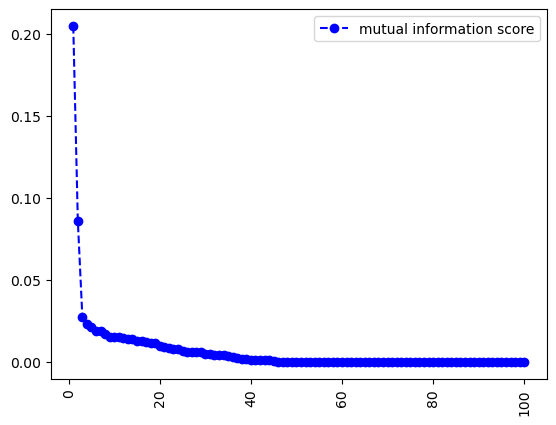

In [5]:
from sklearn.feature_selection import mutual_info_regression

# add lags we set in "lag_list" and place them in order to the dataset.
def Add_Lag(data,col,lag_list):
    position = data.columns.tolist().index(col)

    for lag in lag_list:
        col_val = data[col].shift(lag)
        col_name = col+'_lag:'+'{length}'.format(length=lag)
        data.insert(loc=position, column=col_name, value=col_val)
    return data

def mutual_information_lag(Data,col,n_lag,k_best):
    
    #create a dataset by selecting just one column from Gold dataset; a dataset with just one column of {Open,Close,High,Low,Volume} and time as index
    data = pd.DataFrame(Data[col])
    
    #create the dataset that its columns are lags with different shifts
    mic_df = Add_Lag(data,col,[i+1 for i in range(n_lag)])
    mic_ordered = {}
    
    #calculating the mutual information score between lag columns and target column; one of {Open,Close,High,Low,Volume} which selected above
    for i in range(1,n_lag+1):
        
        i_lag = mic_df[mic_df.columns[mic_df.shape[1]-i-1]][i:]
        i_lag_name = mic_df.columns[mic_df.shape[1]-i-1]
        score = mutual_info_regression(np.array(i_lag).reshape(-1, 1), mic_df[col][i:])
        mic_ordered[i_lag_name] = score[0]
    
    #descend sort the lag list by their mutual information score
    sorted_mic = {k: v for k, v in sorted(mic_ordered.items(),reverse=True, key=lambda item: item[1])}
    
    #select the k first lags that have most mutual information scor
    selected_lags = list(sorted_mic.keys())[:k_best]
    
    #create a list of best k lags obtained above
    select_lag_num = []
    for i in selected_lags:
        
        pos = i.find(':')
        select_lag_num.append(int(i[pos+1:]))
        
    select_lag_num_sort = sorted(select_lag_num)
    
    #draw a plot that visualize all lags (not just best k lags) and their mutul information score with the target
    plt.plot([i+1 for i in range(n_lag)], sorted_mic.values(),'--bo', label = "mutual information score")
    plt.xticks(rotation = 90)
    plt.legend()
    plt.show()
    
    return select_lag_num_sort,sorted_mic,selected_lags,sorted_mic.values()

best_lags = mutual_information_lag(df,'target',100,10)

In [6]:
# Visually, we can see lags 1 and 2 contain the most information
columns_to_lag = ['price', 'open', 'volume']

for col in columns_to_lag:
    for lag in [1,2]:
        df[f'{col}_lag_{lag}'] = df[col].shift(lag)

df.columns

Index(['date', 'price', 'open', 'high', 'low', 'volume', 'change', 'year',
       'month', 'quarter', 'target', 'price_lag_1', 'price_lag_2',
       'open_lag_1', 'open_lag_2', 'volume_lag_1', 'volume_lag_2'],
      dtype='object')

## TA Technical Indicators:

Trend Indicators

Momentum Indicators

Volatility Indicators

In [7]:
# Add Technical Features
import ta

# Initialize ta features (adds automatically NaNs at the beginning)
# 1. Trend Indicators
df['SMA_10'] = ta.trend.SMAIndicator(close=df['price'], window=10).sma_indicator()
df['EMA_10'] = ta.trend.EMAIndicator(close=df['price'], window=10).ema_indicator()
macd = ta.trend.MACD(close=df['price'])
df['MACD'] = macd.macd()
df['MACD_signal'] = macd.macd_signal()
df['MACD_diff'] = macd.macd_diff()

# 2. Momentum Indicators
df['RSI'] = ta.momentum.RSIIndicator(close=df['price'], window=14).rsi()
stoch = ta.momentum.StochasticOscillator(high=df['high'], low=df['low'], close=df['price'])
df['Stoch_K'] = stoch.stoch()
df['Stoch_D'] = stoch.stoch_signal()

# 3. Volatility Indicators
boll = ta.volatility.BollingerBands(close=df['price'], window=20, window_dev=2)
df['BB_upper'] = boll.bollinger_hband()
df['BB_lower'] = boll.bollinger_lband()
df['BB_width'] = df['BB_upper'] - df['BB_lower']

df['ATR'] = ta.volatility.AverageTrueRange(high=df['high'], low=df['low'], close=df['price']).average_true_range()

df.dropna(inplace=True)  # Drop rows with NaN values after adding indicators

In [8]:
df.head()

,date,price,open,high,low,volume,change,year,month,quarter,...,MACD,MACD_signal,MACD_diff,RSI,Stoch_K,Stoch_D,BB_upper,BB_lower,BB_width,ATR
33,2006-02-21,556.6,557.7,559.5,553.9,42.09,0.36,2006,2,1,...,0.126940,1.941141,-1.814202,51.353616,45.083933,37.250200,581.568850,539.031150,42.537701,11.804005
34,2006-02-22,556.6,556.9,557.7,549.8,45.84,0.00,2006,2,1,...,0.266040,1.606121,-1.340081,51.353616,45.083933,43.485212,581.534892,538.915108,42.619784,11.525147
35,2006-02-23,550.9,556.1,558.4,550.3,42.15,-1.02,2006,2,1,...,-0.082711,1.268355,-1.351066,47.672348,32.587065,40.918310,581.304222,537.985778,43.318444,11.280494
36,2006-02-24,561.2,551.5,562.0,549.6,58.72,1.87,2006,2,1,...,0.466646,1.108013,-0.641367,54.078400,58.208955,45.293318,581.379693,538.040307,43.339386,11.360459
37,2006-02-27,557.0,561.0,561.7,554.8,35.16,-0.75,2006,2,1,...,0.556693,0.997749,-0.441056,51.319486,51.752022,47.516014,581.318995,537.921005,43.397991,11.041854


## Macro Features
- USD Index (Yahoo Finance DXY)
- Crude Oil Prices (Yahoo Finance CL=F)
- Stock Market Index (S&P 500 ^GSPC)  
- Volatility Index (VIX ^VIX)

In [9]:
from pandas_datareader import data as pdr

start_date = '2006-03-01'
end_date = '2025-07-01'

# Define macro tickers for FRED data
fred_series = {
    'dxy': 'DTWEXBGS',         # Trade-Weighted U.S. Dollar Index
    'oil': 'DCOILWTICO',       # Crude Oil Prices (WTI)
    'vix': 'VIXCLS',           # CBOE Volatility Index
    'us10y': 'DGS10',          # 10-Year Treasury Yield
    'cpius': 'CPIAUCSL'        # Consumer Price Index for All Urban Consumers: All Items in U.S. City Average 
}

macro_df = pd.DataFrame()

# Download Adjusted Close prices
for name, code in fred_series.items():
    series = pdr.DataReader(code, 'fred', start_date, end_date)
    series.rename(columns={code: name}, inplace=True)
    if macro_df.empty:
        macro_df = series
    else:
        macro_df = macro_df.join(series, how='outer')

# Forward-fill CPI values within each month
macro_df['cpius'] = macro_df['cpius'].fillna(method='ffill')

macro_df

C:\Users\marty\AppData\Local\Temp\ipykernel_29776\2920327055.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  macro_df['cpius'] = macro_df['cpius'].fillna(method='ffill')


,dxy,oil,vix,us10y,cpius
DATE,,,,,
2006-03-01,99.8355,62.01,11.54,4.59,199.7
2006-03-02,99.5969,63.36,11.72,4.64,199.7
2006-03-03,99.7024,63.61,11.96,4.68,199.7
2006-03-06,99.9834,62.46,12.74,4.74,199.7
2006-03-07,100.5640,61.51,12.66,4.74,199.7
...,...,...,...,...,...
2025-06-25,120.7333,65.98,16.76,4.29,321.5
2025-06-26,120.0587,66.44,16.59,4.26,321.5
2025-06-27,120.0786,66.66,16.32,4.29,321.5


In [10]:
# Obtain S&P 500 data from spreadsheet
sp500 = pd.read_csv("S&P 500 Historical Data.csv")
sp500.rename(columns={'Date': 'date', 'Price': 'sp500'}, inplace=True)

# Convert date column to datetime
sp500['date'] = pd.to_datetime(sp500['date'])

# Clean numeric values (remove commas, % if present)
sp500['sp500'] = sp500['sp500'].astype(str).str.replace(',', '')
sp500['sp500'] = pd.to_numeric(sp500['sp500'], errors='coerce')

# Keep only date and close price
sp500 = sp500[['date', 'sp500']]
sp500.sort_values('date', inplace=True)

In [11]:
# Merge with your gold DataFrame
df = df.merge(sp500, on='date', how='left')

# Merge macro data with gold dataframe
# Ensure 'date' is datetime type
df['date'] = pd.to_datetime(df['date'])
macro_df = macro_df.reset_index().rename(columns={'DATE': 'date'})

# Merge
df = df.merge(macro_df, on='date', how='left')

# Calculate percentage changes for macro features
macro_cols = ['dxy', 'oil', 'sp500', 'vix', 'us10y']
for col in macro_cols:
    df[f'{col}_pct_change'] = df[col].pct_change(fill_method=None)

# Drop missing rows
df.sort_values('date', inplace=True)
df.dropna(inplace=True)
df.set_index('date', inplace=True)


In [12]:
df.head()

,price,open,high,low,volume,change,year,month,quarter,target,...,dxy,oil,vix,us10y,cpius,dxy_pct_change,oil_pct_change,sp500_pct_change,vix_pct_change,us10y_pct_change
date,,,,,,,,,,,,,,,,,,,,,
2006-03-02,570.4,565.6,570.8,563.7,49.55,0.81,2006,3,1,0,...,99.5969,63.36,11.72,4.64,199.7,-0.002390,0.021771,-0.001626,0.015598,0.010893
2006-03-03,568.0,570.6,572.5,566.2,44.15,-0.42,2006,3,1,0,...,99.7024,63.61,11.96,4.68,199.7,0.001059,0.003946,-0.001474,0.020478,0.008621
2006-03-06,556.8,567.5,570.2,553.5,64.52,-1.97,2006,3,1,0,...,99.9834,62.46,12.74,4.74,199.7,0.002818,-0.018079,-0.006914,0.065217,0.012821
2006-03-07,554.5,556.5,559.8,549.6,72.67,-0.41,2006,3,1,0,...,100.5640,61.51,12.66,4.74,199.7,0.005807,-0.015210,-0.001877,-0.006279,0.000000
2006-03-08,544.3,554.0,555.4,539.5,89.86,-1.84,2006,3,1,1,...,100.8565,60.06,12.32,4.73,199.7,0.002909,-0.023573,0.002038,-0.026856,-0.002110


## Data Analysis

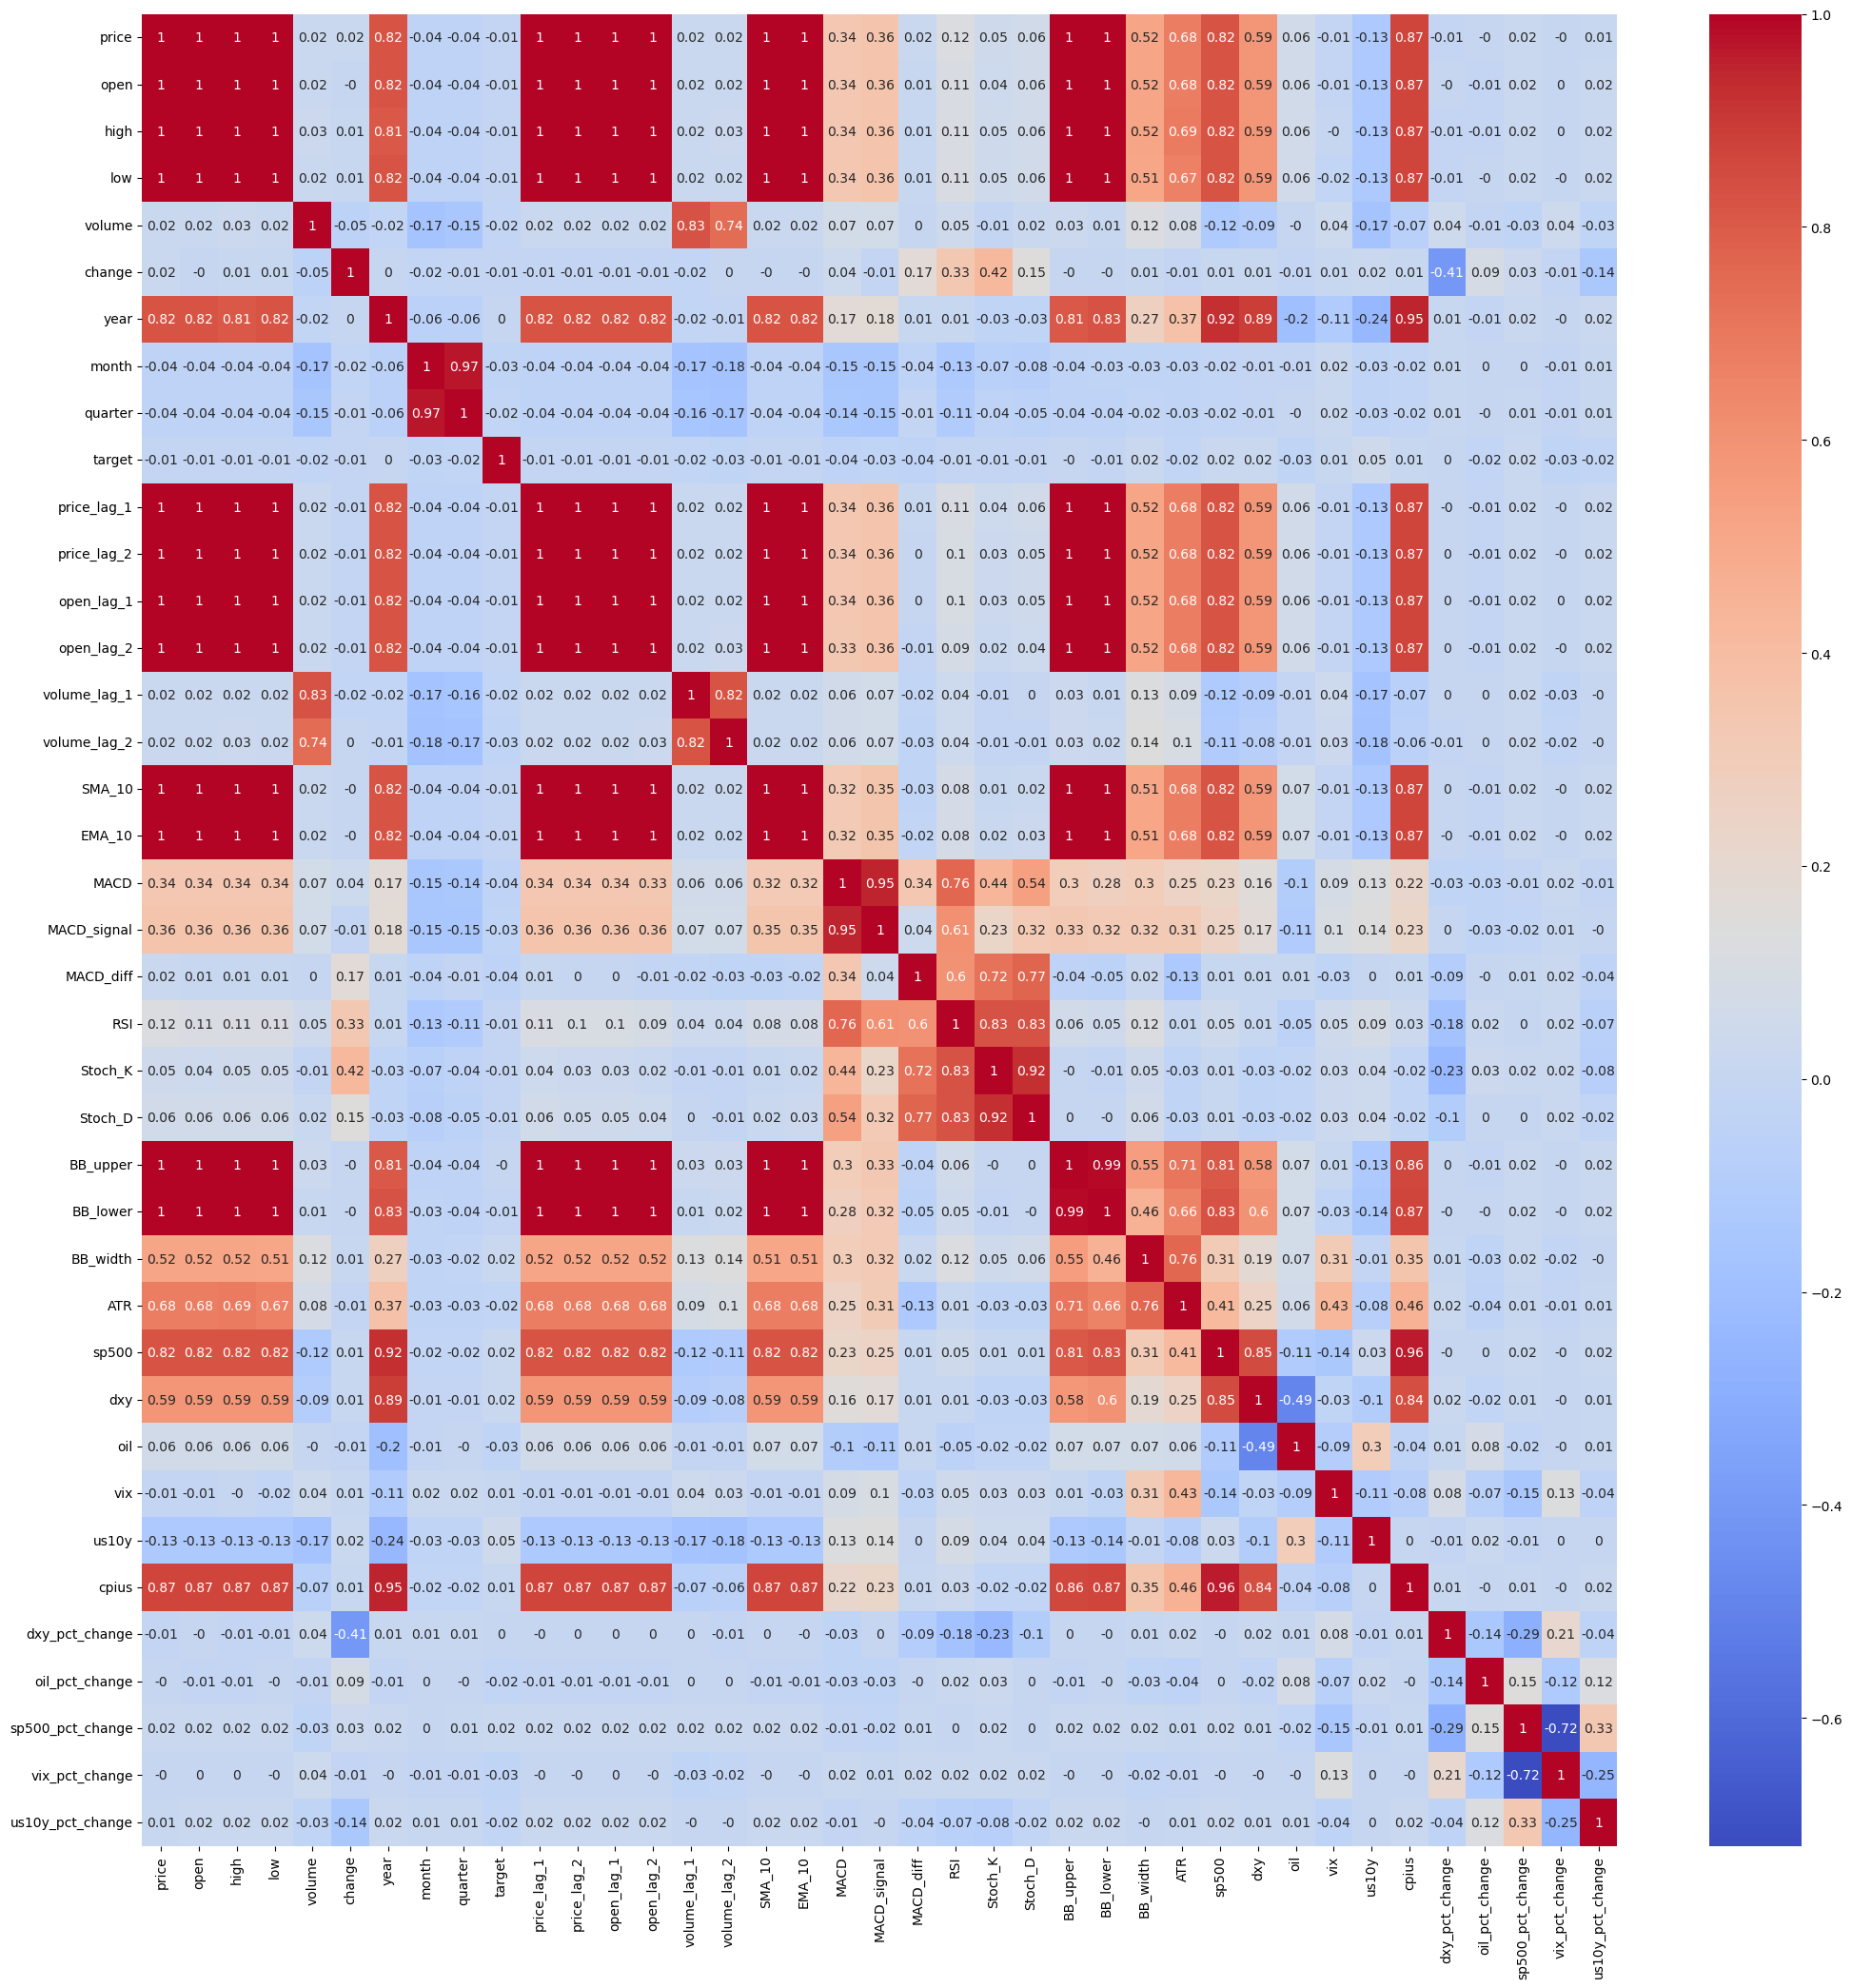

In [13]:
import seaborn as sns

corr = round(df.corr(numeric_only=True),2)
plt.figure(figsize=(25, 25))
heatmap = sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

## Split Dataset

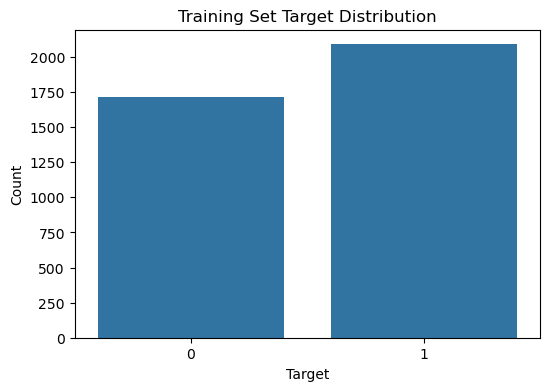

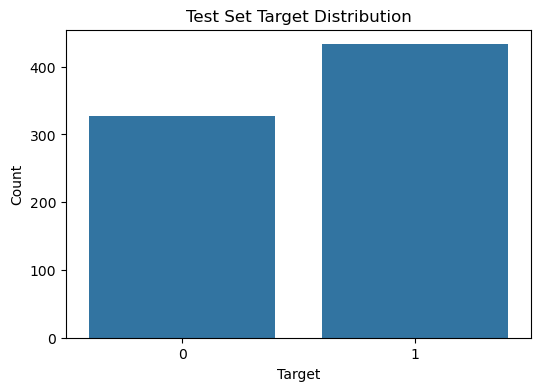

In [14]:
from sklearn.model_selection import TimeSeriesSplit

feature_columns = ['date', 'price', 'open', 'high', 'low', 'volume', 'change', 'year',
       'month', 'quarter', 'price_lag_1', 'price_lag_2', 'open_lag_1',
       'open_lag_2', 'volume_lag_1', 'volume_lag_2', 'SMA_10', 'EMA_10',
       'MACD', 'MACD_signal', 'MACD_diff', 'RSI', 'Stoch_K', 'Stoch_D',
       'BB_upper', 'BB_lower', 'BB_width', 'ATR', 'sp500', 'dxy', 'oil', 'vix',
       'us10y', 'cpius', 'dxy_pct_change', 'oil_pct_change',
       'sp500_pct_change', 'vix_pct_change', 'us10y_pct_change']

X = df.drop(labels=['target'], axis=1)
y = df['target']

tss = TimeSeriesSplit(n_splits = 5)
for train_index, test_index in tss.split(X):
    X_train_full, X_test_final= X.iloc[train_index, :], X.iloc[test_index,:]
    y_train_full, y_test_final = y.iloc[train_index], y.iloc[test_index]

# Plot Training Set Distribution
plt.figure(figsize=(6,4))
sns.countplot(x=y_train_full)
plt.title('Training Set Target Distribution')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

# Plot Test Set Distribution
plt.figure(figsize=(6,4))
sns.countplot(x=y_test_final)
plt.title('Test Set Target Distribution')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

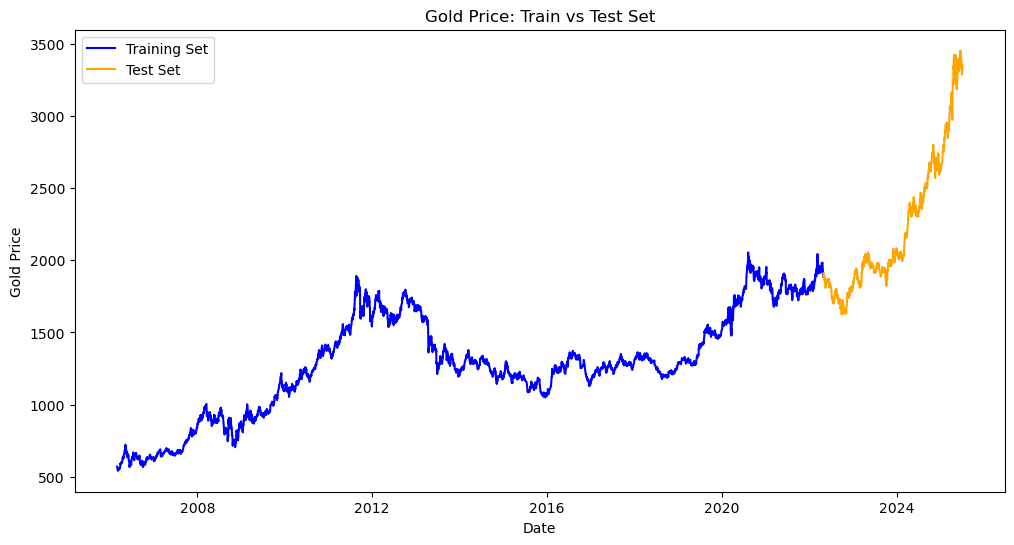

In [15]:
# Get train/test date ranges
train_dates = X_train_full.index
test_dates = X_test_final.index

plt.figure(figsize=(12,6))
plt.plot(df.loc[train_dates, 'price'], label='Training Set', color='blue')
plt.plot(df.loc[test_dates, 'price'], label='Test Set', color='orange')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.title('Gold Price: Train vs Test Set')
plt.legend()
plt.show()

In [16]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb

# Define the model parameters lists for hyperparameter tuning
param_grids = {
    'log_reg': {'model__C': [0.01, 0.03, 0.05, 0.1]},
    'rf': {'model__n_estimators': [100, 200], 'model__max_depth': [3, 5, 10]},
    'ada': {'model__n_estimators': [50, 100, 200], 'model__learning_rate': [0.5, 1.0]},
    'xgb': {'model__n_estimators': [200, 400], 'model__max_depth': [3, 5], 'model__learning_rate': [0.01, 0.1]},
    'lgb': {'model__n_estimators': [200, 400], 'model__max_depth': [-1, 5], 'model__learning_rate': [0.01, 0.1]},
    'gbdt': {'model__n_estimators': [100, 200], 'model__max_depth': [3, 5], 'model__learning_rate': [0.05, 0.1]}
}

# Fixed Random State
STATE = 42

# Pipeline Creation
pipelines = {
    'log_reg': Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(max_iter=1000, class_weight='balanced'))
    ]),
    'gbdt': Pipeline([
        ('model', GradientBoostingClassifier(random_state=STATE))
    ]),
    'rf': Pipeline([
        ('model', RandomForestClassifier(random_state=STATE))
    ]),
    'xgb': Pipeline([
        ('model', xgb.XGBClassifier(eval_metric='logloss', random_state=STATE))
    ]),
    'lgb': Pipeline([
        ('model', lgb.LGBMClassifier(random_state=STATE, verbose=-1))
    ]),
    'ada': Pipeline([
        ('model', AdaBoostClassifier(random_state=STATE))
    ])
}

In [17]:
tss = TimeSeriesSplit(n_splits=5)
metrics_summary = []
best_models = {}
best_params = {}   # Dictionary to store best hyperparameters

for name, pipe in pipelines.items():
    print(f"\nTuning and evaluating {name}...")
    grid = GridSearchCV(pipe, param_grids[name], cv=tss, scoring='roc_auc', n_jobs=-1)
    grid.fit(X_train_full, y_train_full)
    best_model = grid.best_estimator_
    best_models[name] = best_model
    best_params[name] = grid.best_params_ 

    # Cross-validated training metrics
    train_scores = []
    for train_idx, val_idx in tss.split(X_train_full):
        X_train, X_val = X_train_full.iloc[train_idx], X_train_full.iloc[val_idx]
        y_train, y_val = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]

        best_model.fit(X_train, y_train)
        y_val_pred = best_model.predict(X_val)
        y_val_proba = best_model.predict_proba(X_val)[:,1]

        train_scores.append([
            accuracy_score(y_val, y_val_pred),
            precision_score(y_val, y_val_pred),
            recall_score(y_val, y_val_pred),
            f1_score(y_val, y_val_pred),
            roc_auc_score(y_val, y_val_proba)
        ])

    train_scores = np.array(train_scores)
    train_metrics = train_scores.mean(axis=0)

    # Final test metrics on last 20%
    best_model.fit(X_train_full, y_train_full)
    y_test_pred = best_model.predict(X_test_final)
    y_test_proba = best_model.predict_proba(X_test_final)[:,1]

    test_metrics = [
        accuracy_score(y_test_final, y_test_pred),
        precision_score(y_test_final, y_test_pred),
        recall_score(y_test_final, y_test_pred),
        f1_score(y_test_final, y_test_pred),
        roc_auc_score(y_test_final, y_test_proba)
    ]

    metrics_summary.append({
        'Model': name,
        'CV Accuracy': train_metrics[0],
        'CV Precision': train_metrics[1],
        'CV Recall': train_metrics[2],
        'CV F1': train_metrics[3],
        'CV ROC-AUC': train_metrics[4],
        'Test Accuracy': test_metrics[0],
        'Test Precision': test_metrics[1],
        'Test Recall': test_metrics[2],
        'Test F1': test_metrics[3],
        'Test ROC-AUC': test_metrics[4]
    })

metrics_df = pd.DataFrame(metrics_summary)

# Print the best hyperparameters for each model
print("\nBest Hyperparameters for Each Model:")
for model, params in best_params.items():
    print(f"{model}: {params}")

# Show both metrics and hyperparameters
print("\nCross-Validated Training Metrics and Final Test Metrics:")
print(metrics_df)




Tuning and evaluating log_reg...

Tuning and evaluating gbdt...

Tuning and evaluating rf...


c:\Programming\Resources\miniconda3\envs\applied_project\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



Tuning and evaluating xgb...


c:\Programming\Resources\miniconda3\envs\applied_project\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



Tuning and evaluating lgb...

Tuning and evaluating ada...


c:\Programming\Resources\miniconda3\envs\applied_project\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



Best Hyperparameters for Each Model:
log_reg: {'model__C': 0.05}
gbdt: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 200}
rf: {'model__max_depth': 10, 'model__n_estimators': 100}
xgb: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 200}
lgb: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 200}
ada: {'model__learning_rate': 1.0, 'model__n_estimators': 200}

Cross-Validated Training Metrics and Final Test Metrics:
     Model  CV Accuracy  CV Precision  CV Recall     CV F1  CV ROC-AUC  \
0  log_reg     0.471924      0.567505   0.254088  0.269920    0.519519   
1     gbdt     0.474132      0.651487   0.351127  0.340601    0.525117   
2       rf     0.505678      0.457453   0.458210  0.428009    0.521182   
3      xgb     0.497476      0.436321   0.541239  0.474390    0.515205   
4      lgb     0.483596      0.546330   0.453040  0.435397    0.498617   
5      ada     0.466877      0.419826   0.312238  0.3

In [18]:
# Identify best model based on Test F1 or ROC-AUC
best_model_index = metrics_df['Test F1'].idxmax()
best_model_name = metrics_df.iloc[best_model_index]["Model"]
final_model = best_models[best_model_name]
final_params = best_params[best_model_name]

print(f"\nBest model: {best_model_name}")
print(f"Best hyperparameters: {final_params}")

# Retrain on full training data
final_model.fit(X_train_full, y_train_full)

# Get probabilities on the test set
y_train_proba = final_model.predict_proba(X_train_full)[:, 1]
y_test_proba = final_model.predict_proba(X_test_final)[:, 1]

# Threshold range
thresholds = np.arange(0.35, 0.71, 0.01) 

metrics_list = []

for t in thresholds:
    y_pred_thresh = (y_test_proba >= t).astype(int)
    prec = precision_score(y_test_final, y_pred_thresh)
    rec = recall_score(y_test_final, y_pred_thresh)
    f1 = f1_score(y_test_final, y_pred_thresh)
    roc_auc = roc_auc_score(y_test_final, y_pred_thresh)

    metrics_list.append({
        'Threshold': round(t, 2),
        'Precision': prec,
        'Recall': rec,
        'F1': f1,
    })

# Convert to DataFrame
threshold_metrics_df = pd.DataFrame(metrics_list)

print(threshold_metrics_df)
best_threshold = threshold_metrics_df.loc[threshold_metrics_df['F1'].idxmax(), 'Threshold']
print(f"\nOptimal Threshold: {best_threshold}")


Best model: log_reg
Best hyperparameters: {'model__C': 0.05}
    Threshold  Precision    Recall        F1
0        0.35   0.573222  0.949192  0.714783
1        0.36   0.575246  0.944573  0.715035
2        0.37   0.577904  0.942263  0.716418
3        0.38   0.576758  0.928406  0.711504
4        0.39   0.578792  0.907621  0.706835
5        0.40   0.581465  0.898383  0.705989
6        0.41   0.576687  0.868360  0.693088
7        0.42   0.570747  0.829099  0.676083
8        0.43   0.569787  0.801386  0.666027
9        0.44   0.564626  0.766744  0.650343
10       0.45   0.557726  0.725173  0.630522
11       0.46   0.557621  0.692841  0.617920
12       0.47   0.552734  0.653580  0.598942
13       0.48   0.547131  0.616628  0.579805
14       0.49   0.547414  0.586605  0.566332
15       0.50   0.547945  0.554273  0.551091
16       0.51   0.546135  0.505774  0.525180
17       0.52   0.551913  0.466513  0.505632
18       0.53   0.569733  0.443418  0.498701
19       0.54   0.583062  0.413395  0.

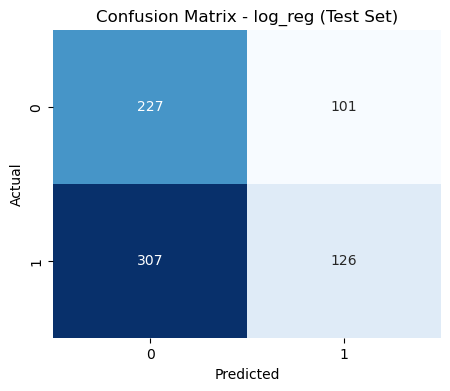

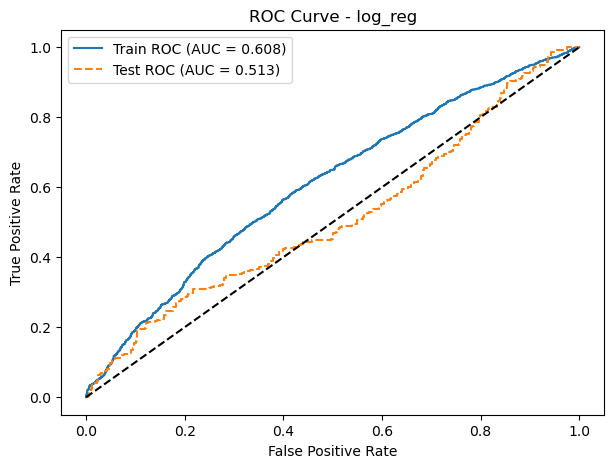

In [19]:
# Confusion Matrix on test set
cm = confusion_matrix(y_test_final, y_test_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix - {best_model_name} (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curves for Train and Test
fpr_train, tpr_train, _ = roc_curve(y_train_full, y_train_proba)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = roc_curve(y_test_final, y_test_proba)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(7,5))
plt.plot(fpr_train, tpr_train, label=f'Train ROC (AUC = {roc_auc_train:.3f})')
plt.plot(fpr_test, tpr_test, label=f'Test ROC (AUC = {roc_auc_test:.3f})', linestyle='--')
plt.plot([0,1], [0,1], 'k--')
plt.title(f'ROC Curve - {best_model_name}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## Backtesting Strategy

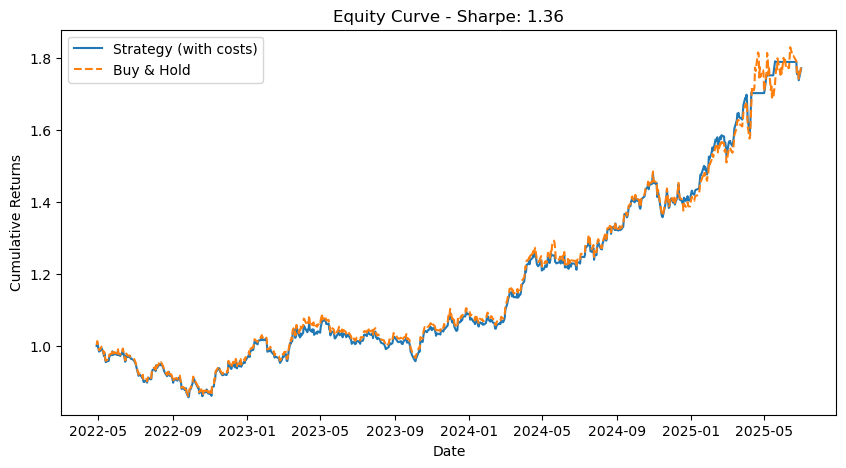

Backtest Results (with costs):
Precision: 0.5779
Recall: 0.9423
F1: 0.7164
Sharpe: 1.3621
Cumulative Return: 0.7722


In [20]:
from math import sqrt

def backtest_model(model, 
                   X_train, y_train, 
                   X_test, y_test, 
                   price_series, 
                   threshold=0.5, 
                   position_size=1.0, 
                   transaction_cost=0.001):
    """
    Backtests a classification-based trading strategy with transaction costs and position sizing.

    model: trained sklearn pipeline/model
    X_train, y_train: training data
    X_test, y_test: test data
    price_series: price column aligned with X_test index
    threshold: classification probability threshold (default 0.5)
    position_size: fraction of capital allocated to each trade (0 < size <= 1)
    transaction_cost: proportional cost per trade (e.g., 0.001 = 0.1%)
    """

    # Train the model
    model.fit(X_train, y_train)

    # Get predicted probabilities
    y_proba = model.predict_proba(X_test)[:, 1]

    # Apply threshold
    y_pred = (y_proba >= threshold).astype(int)

    # Shift to avoid lookahead bias
    signals = pd.Series(y_pred, index=X_test.index).shift(1).fillna(0)

    # Daily returns for the asset
    returns = price_series.pct_change().loc[X_test.index].fillna(0)

    # Strategy returns before costs
    raw_strategy_returns = signals * returns * position_size

    # Apply transaction costs (when signal changes position)
    trades = signals.diff().abs().fillna(0)
    cost_adjustment = trades * transaction_cost
    strategy_returns = raw_strategy_returns - cost_adjustment

    # Cumulative returns
    cumulative_strategy = (1 + strategy_returns).cumprod()
    cumulative_asset = (1 + returns).cumprod()

    # Sharpe Ratio
    mean_ret = strategy_returns.mean()
    std_ret = strategy_returns.std()
    sharpe_ratio = (mean_ret / std_ret) * sqrt(252) if std_ret != 0 else 0

    # Metrics
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Plot equity curves
    plt.figure(figsize=(10,5))
    plt.plot(cumulative_strategy, label='Strategy (with costs)')
    plt.plot(cumulative_asset, label='Buy & Hold', linestyle='--')
    plt.title(f'Equity Curve - Sharpe: {sharpe_ratio:.2f}')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.show()

    return {
        'Precision': prec,
        'Recall': rec,
        'F1': f1,
        'Sharpe': sharpe_ratio,
        'Cumulative Return': cumulative_strategy.iloc[-1] - 1
    }

results = backtest_model(final_model,
                         X_train_full, y_train_full,
                         X_test_final, y_test_final,
                         df['price'],
                         threshold=best_threshold,
                         transaction_cost=0.001) # 0.1% cost per trade

print("Backtest Results (with costs):")
for k, v in results.items():
    print(f"{k}: {v:.4f}")

In [21]:
def max_drawdown(cumulative_returns):
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min()

def expanding_backtest(model, X, y, price_series,
                       min_train_size=252, test_window=21,
                       threshold=0.5, transaction_cost=0.0000,
                       position_size=1.0):
    all_y_true, all_y_proba, all_y_pred = [], [], []
    strategy_returns_all = []

    start = min_train_size
    while start + test_window <= len(X):
        X_train, y_train = X.iloc[:start], y.iloc[:start]
        X_test, y_test = X.iloc[start:start+test_window], y.iloc[start:start+test_window]

        model.fit(X_train, y_train)
        y_proba = model.predict_proba(X_test)[:,1]
        y_pred = (y_proba >= threshold).astype(int)

        all_y_true.extend(y_test)
        all_y_proba.extend(y_proba)
        all_y_pred.extend(y_pred)

        # Trading signals
        signals = pd.Series(y_pred, index=X_test.index).shift(1).fillna(0)
        returns = price_series.pct_change().loc[X_test.index].fillna(0)

        raw_returns = signals * returns * position_size
        trades = signals.diff().abs().fillna(0)
        strategy_returns = raw_returns - trades * transaction_cost

        strategy_returns_all.append(strategy_returns)

        start += test_window

    strategy_returns_all = pd.concat(strategy_returns_all)
    cumulative = (1 + strategy_returns_all).cumprod()

    mean_ret = strategy_returns_all.mean()
    std_ret = strategy_returns_all.std()
    downside_std = strategy_returns_all[strategy_returns_all < 0].std()

    return {
        'AUC': roc_auc_score(all_y_true, all_y_proba),
        'Accuracy': accuracy_score(all_y_true, all_y_pred),
        'Sharpe': (mean_ret / std_ret) * sqrt(252) if std_ret != 0 else 0,
        'Sortino': (mean_ret / downside_std) * sqrt(252) if downside_std != 0 else 0,
        'Max Drawdown': max_drawdown(cumulative),
        'Cumulative Return': cumulative.iloc[-1] - 1
    }, strategy_returns_all


def rolling_backtest(model, X, y, price_series,
                     train_window=252, test_window=21,
                     threshold=0.5, transaction_cost=0.000,
                     position_size=1.0):
    all_y_true, all_y_proba, all_y_pred = [], [], []
    strategy_returns_all = []

    start = 0
    while start + train_window + test_window <= len(X):
        X_train, y_train = X.iloc[start:start+train_window], y.iloc[start:start+train_window]
        X_test, y_test = X.iloc[start+train_window:start+train_window+test_window], y.iloc[start+train_window:start+train_window+test_window]

        model.fit(X_train, y_train)
        y_proba = model.predict_proba(X_test)[:,1]
        y_pred = (y_proba >= threshold).astype(int)

        all_y_true.extend(y_test)
        all_y_proba.extend(y_proba)
        all_y_pred.extend(y_pred)

        signals = pd.Series(y_pred, index=X_test.index).shift(1).fillna(0)
        returns = price_series.pct_change().loc[X_test.index].fillna(0)

        raw_returns = signals * returns * position_size
        trades = signals.diff().abs().fillna(0)
        strategy_returns = raw_returns - trades * transaction_cost

        strategy_returns_all.append(strategy_returns)

        start += test_window

    strategy_returns_all = pd.concat(strategy_returns_all)
    cumulative = (1 + strategy_returns_all).cumprod()

    mean_ret = strategy_returns_all.mean()
    std_ret = strategy_returns_all.std()
    downside_std = strategy_returns_all[strategy_returns_all < 0].std()

    return {
        'AUC': roc_auc_score(all_y_true, all_y_proba),
        'Accuracy': accuracy_score(all_y_true, all_y_pred),
        'Sharpe': (mean_ret / std_ret) * sqrt(252) if std_ret != 0 else 0,
        'Sortino': (mean_ret / downside_std) * sqrt(252) if downside_std != 0 else 0,
        'Max Drawdown': max_drawdown(cumulative),
        'Cumulative Return': cumulative.iloc[-1] - 1
    }, strategy_returns_all

def buy_and_hold_metrics(price_series):
    returns = price_series.pct_change().dropna()
    cumulative = (1 + returns).cumprod()
    
    mean_ret = returns.mean()
    std_ret = returns.std()
    downside_std = returns[returns < 0].std()
    
    sharpe = (mean_ret / std_ret) * np.sqrt(252) if std_ret != 0 else 0
    sortino = (mean_ret / downside_std) * np.sqrt(252) if downside_std != 0 else 0
    mdd = max_drawdown(cumulative)
    
    return {
        'AUC': np.nan,  # not applicable
        'Accuracy': np.nan,  # not applicable
        'Sharpe': sharpe,
        'Sortino': sortino,
        'Max Drawdown': mdd,
        'Cumulative Return': cumulative.iloc[-1] - 1
    }, returns


In [22]:
# Assume best model is already trained/tuned
# best_model_name = metrics_df['Test F1'].idxmax()
# final_model = best_models[best_model_name]

# Run expanding
expanding_results, expanding_returns = expanding_backtest(final_model, X, y, df['price'],
                                       min_train_size=252, test_window=21,
                                       threshold=best_threshold)

# Run rolling for 1-year and 2-year windows
rolling_1yr, rolling_1yr_returns = rolling_backtest(final_model, X, y, df['price'],
                               train_window=252, test_window=21,
                               threshold=best_threshold)

rolling_2yr, rolling_2yr_returns = rolling_backtest(final_model, X, y, df['price'],
                               train_window=504, test_window=21,
                               threshold=best_threshold)

bh_metrics, bh_returns = buy_and_hold_metrics(df['price'])

# Combine into DataFrame
results_df = pd.DataFrame([
    {'Type': 'Expanding', **expanding_results},
    {'Type': 'Rolling 1yr', **rolling_1yr},
    {'Type': 'Rolling 2yr', **rolling_2yr},
    {'Type': 'Buy & Hold', **bh_metrics}
])

print("Backtesting Comparison:")
print(results_df)

Backtesting Comparison:
          Type       AUC  Accuracy    Sharpe   Sortino  Max Drawdown  \
0    Expanding  0.526379  0.538676  0.835671  1.004031     -0.343133   
1  Rolling 1yr  0.521445  0.534727  0.599427  0.655424     -0.341400   
2  Rolling 2yr  0.533004  0.533679  0.488804  0.556466     -0.394775   
3   Buy & Hold       NaN       NaN  0.621998  0.831340     -0.445214   

   Cumulative Return  
0           6.382490  
1           2.765185  
2           1.746519  
3           4.873860  


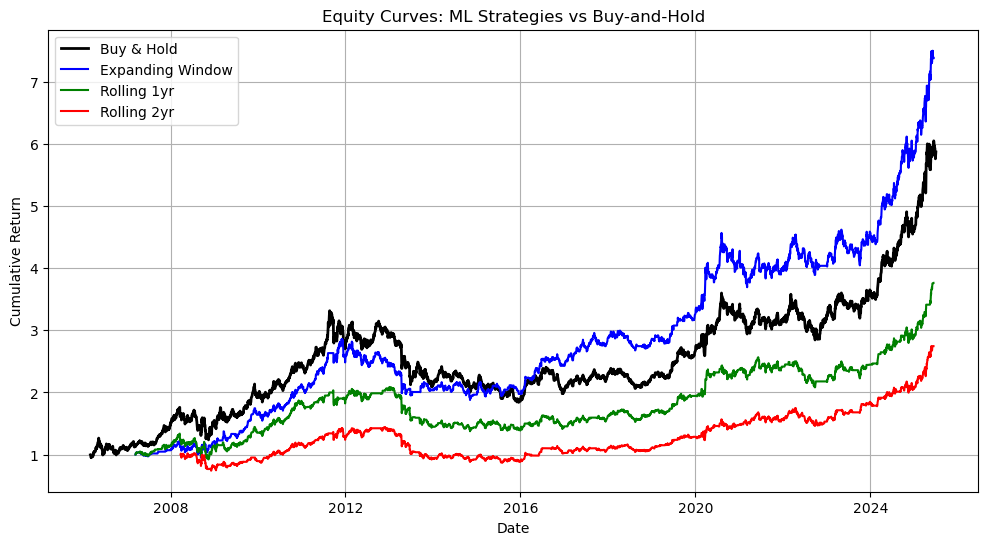

In [23]:
def plot_equity_curves(price_series, expanding_returns, rolling1_returns, rolling2_returns):
    # Compute cumulative equity curves
    bh_equity = (1 + price_series.pct_change().dropna()).cumprod()
    expanding_equity = (1 + expanding_returns).cumprod()
    rolling1_equity = (1 + rolling1_returns).cumprod()
    rolling2_equity = (1 + rolling2_returns).cumprod()

    plt.figure(figsize=(12, 6))
    plt.plot(bh_equity.index, bh_equity, label='Buy & Hold', color='black', linewidth=2)
    plt.plot(expanding_equity.index, expanding_equity, label='Expanding Window', color='blue')
    plt.plot(rolling1_equity.index, rolling1_equity, label='Rolling 1yr', color='green')
    plt.plot(rolling2_equity.index, rolling2_equity, label='Rolling 2yr', color='red')

    plt.title('Equity Curves: ML Strategies vs Buy-and-Hold')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_equity_curves(df['price'], expanding_returns, rolling_1yr_returns, rolling_2yr_returns)